In [6]:
## import io
import ipywidgets as widgets
import matplotlib.pyplot as plt
import PIL.Image
import numpy as np
import urllib
from skimage.transform import resize
from matplotlib.image import imread
import os
from IPython.display import display
from skimage import io as io_url
import cv2
import numpy as np
from PIL import Image
import io


In [211]:
# Create image widgets
image3_spatial = widgets.Image(format='png', width=500, height=500, description='Spatial')
image3_freq    = widgets.Image(format='png', width=500, height=500, description='Frequency')
sidebyside     = widgets.HBox([image3_spatial, image3_freq])

# Create slider/select widgets
slider_inner   = widgets.FloatSlider(value=0,      min=0, max=1,      step=0.01, description='Inner radius')
slider_outer   = widgets.FloatSlider(value=1.44/2, min=0, max=1.44/2, step=0.01, description='Outer radius')

buf            = io.BytesIO()

orig_img = io_url.imread('https://img2.zergnet.com/2309662_300.jpg')
orig_img = np.mean(orig_img, -1)

x = np.fft.fftfreq(orig_img.shape[0]);
y = np.fft.fftfreq(orig_img.shape[1]);

xv, yv = np.meshgrid(x, y)
xv = np.fft.fftshift(xv)
yv = np.fft.fftshift(yv)

def filter_frequency(orig_img, mask):
    """
    You need to remove frequency based on the given mask.
    Params:
    orig_img: numpy image
    mask: same shape with orig_img indicating which frequency hold or remove
    Output:
    f_img: frequency image after applying mask
    img: image after applying mask
    """
    # You need to implement this function
    # Convert image to grayscale if it's RGB
    if len(orig_img.shape) == 3:
        orig_img = orig_img.mean(axis=2)

    # 1. Transform using fft2
    f = np.fft.fft2(orig_img)

    # 2. Shift frequency coefs to center using fftshift
    f_shifted = np.fft.fftshift(f)

    # 3. Apply mask to filter frequencies
    filtered_f = f_shifted * mask

    # 4. Shift frequency coefs back using ifftshift
    filtered_f_ishifted = np.fft.ifftshift(filtered_f)

    # 5. Invert transform using ifft2
    img = np.fft.ifft2(filtered_f_ishifted).real

    # Clip to avoid potential artifacts
    img = np.clip(img, 0, 255)

    return filtered_f.astype(np.float32), img.astype(np.uint8)

def on_value_change3(change):
    mask = (np.sqrt(xv**2 + yv**2) < slider_outer.value) & \
           (np.sqrt(xv**2 + yv**2) >= slider_inner.value)
    mask = np.float32(mask)

    fimg, img = filter_frequency(orig_img, mask)
    buf.seek(0)
    tmp = PIL.Image.fromarray(255*img + 0.00001) #/(img.max()+0.0001))# (255*img/(img.max()+0.0001))
    tmp = tmp.convert('L')
    tmp.save(buf, 'png')

    image3_spatial.value = buf.getvalue()

    buf.seek(0)
    tmp = PIL.Image.fromarray(255*np.log(0.0001*fimg + 1))
    tmp = tmp.convert('L')
    tmp.save(buf, 'png')
    image3_freq.value = buf.getvalue()


slider_inner.observe(on_value_change3, names='value')
slider_outer.observe(on_value_change3, names='value')

on_value_change3(0)

display(sidebyside)
display(slider_inner)
display(slider_outer)

/tmp/ipykernel_33/363201583.py:55: ComplexWarning: Casting complex values to real discards the imaginary part
  return filtered_f.astype(np.float32), img.astype(np.uint8)
/tmp/ipykernel_33/363201583.py:71: RuntimeWarning: invalid value encountered in log
  tmp = PIL.Image.fromarray(255*np.log(0.0001*fimg + 1))


FloatSlider(value=0.0, description='Inner radius', max=1.0, step=0.01)

FloatSlider(value=0.72, description='Outer radius', max=0.72, step=0.01)

In [233]:
def read_img(img_path, img_size=(512, 512)):
    """
    + Đọc ảnh
    + Chuyển thành grayscale
    + Thay đổi kích thước ảnh thành img_size
    """
    img = cv2.imread(img_path, 0)
    img = cv2.resize(img, img_size)
    return img

def read_img_from_url(img_path, img_size=(512, 512)):
    """
    + Đọc ảnh
    + Chuyển thành grayscale
    + Thay đổi kích thước ảnh thành img_size
    """
    img = io_url.imread(img_path)
    img = cv2.resize(img, img_size)
    return img

def create_hybrid_img(img1, img2, r):
    """
    Create hydrid image
    Params:
    img1: numpy image 1
    img2: numpy image 2
    r: radius that defines the filled circle of frequency of image 1. Refer to the homework title to know more.
    """
    # You need to implement the function

    # Ensure images have the same dimensions
    if img1.shape != img2.shape:
        raise ValueError("Input images must have the same dimensions.")

    # Convert images to grayscale if they are RGB
    if len(img1.shape) == 3:
        img1 = img1.mean(axis=2)
        img2 = img2.mean(axis=2)

    # 1. Transform using fft2
    f1 = np.fft.fft2(img1)
    f2 = np.fft.fft2(img2)

    # 2. Shift frequency coefs to center using fftshift
    f1_shifted = np.fft.fftshift(f1)
    f2_shifted = np.fft.fftshift(f2)

    # 3. Create a mask based on the given radius (r) parameter
    rows, cols = img1.shape
    center_x = int(cols / 2)
    center_y = int(rows / 2)
    mask = np.zeros((rows, cols))
    y, x = np.ogrid[:rows, :cols]
    mask = np.sqrt((x - center_x)**2 + (y - center_y)**2) <= r

    # 4. Combine frequency of 2 images using the mask
    hybrid_f = f1_shifted * mask + f2_shifted * (1 - mask)

    # 5. Shift frequency coefs back using ifftshift
    hybrid_f_ishifted = np.fft.ifftshift(hybrid_f)

    # 6. Invert transform using ifft2
    hybrid_img = np.fft.ifft2(hybrid_f_ishifted).real

    # Clip to avoid potential artifacts
    hybrid_img = np.clip(hybrid_img, 0, 255)

    return hybrid_img.astype(np.uint8)

(-0.5, 511.5, 511.5, -0.5)

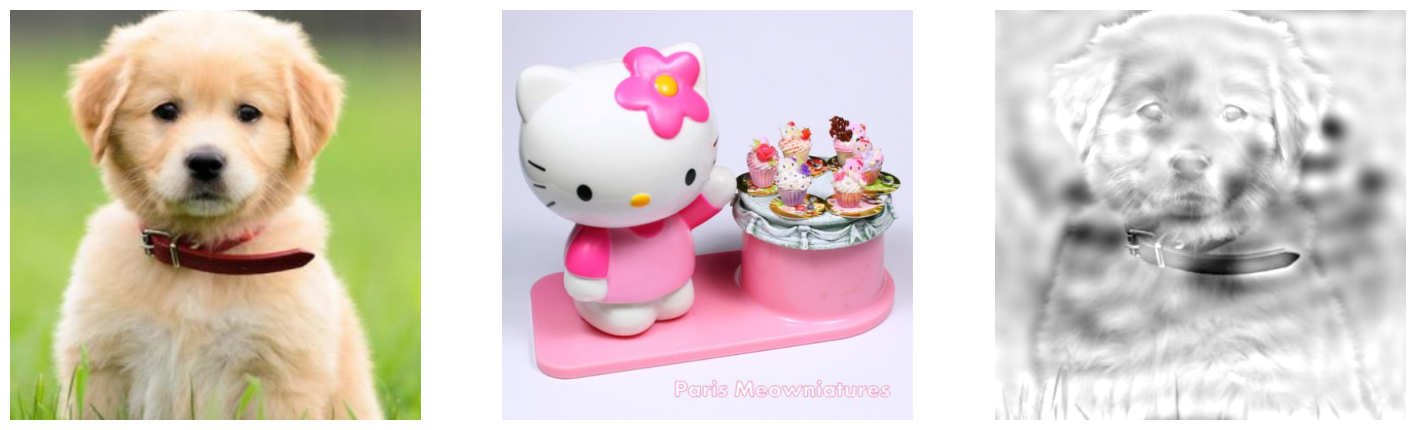

In [234]:
image_1_path = "https://img2.zergnet.com/2309662_300.jpg" # <-- need to change
image_2_path = "https://i.pinimg.com/originals/92/6e/c3/926ec3619fb15062bfeca312e504f15b.jpg" # <-- need to change

img_1 = read_img_from_url(image_1_path)

img_2 = read_img_from_url(image_2_path)

#img_1 = read_img(image_1_path)
#img_2 = read_img(image_2_path)
hybrid_img = create_hybrid_img(img_2, img_1, 14)
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 15))
axes[0].imshow(img_1, cmap="gray")
axes[0].axis("off")
axes[1].imshow(img_2, cmap="gray")
axes[1].axis("off")
axes[2].imshow(hybrid_img, cmap="gray")
axes[2].axis("off")